In [9]:
from konlpy.tag import Okt#한글 토큰 클래스
from tensorflow.keras.preprocessing.text import Tokenizer#토큰화 클래스
from tensorflow.keras.preprocessing.sequence import pad_sequences#정규패딩
from sklearn.preprocessing import LabelEncoder#수치형데이터화 클래스
from sklearn.model_selection import train_test_split#학습테스트 스플릿
from tensorflow.keras.utils import to_categorical#원핫인코딩화
import numpy as np#넘파이사용
from nltk.corpus import stopwords#불용어
from bs4 import BeautifulSoup#웹
import re#정규식
from tqdm import tqdm#진행도 시각화
import pandas as pd#판다스사용
import numpy as np
train_data = pd.read_table('ratings_train (1).txt')[['document','label']]
test_data = pd.read_table('ratings_test (2).txt')[['document','label']]
data=pd.concat((train_data,test_data),axis=0)

data=data.rename(columns = {'label':'y', 'document' : 'X'}) #이름바꿈
    #불용어 추가
okt=Okt()#한글 명사로 토큰화 처리
s_w=set(['은','는','이','가','를','들','에게','의','을','도','으로','만','라서','하다'])
    #s_w.add(불용어 추가문자열) #추가할 붕용어는 add를 이용하여 입력
okt=Okt()#형태소 분석기(자율)

class 한글_전처리기:            
    
    def __init__(self, data):

        data=data.drop_duplicates(subset=['X'])#X의 중복제거(set과 비슷)
        data['clean_X']=data.X.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','') #한글외 정리
        data['clean_X']=data.clean_X.str.replace('^ +','')#공백 시작문자 정리
        data['clean_X']=data.clean_X.replace('',np.nan) #공백을 nan으로
        data=data.dropna(how='any') #nan값 모두 제거        
        self.data=data

    def ck_m(self):
        print(f'결측치 확인:{self.data.isnull().values.any()}')
        print(f"X 중복 확인:{self.data['clean_X'].nunique(), len(self.data['clean_X'])}\n"
              f"y 중복 확인:{self.data['y'].nunique(), len(self.data['y'])}")

    def 전처리_결과_출력(self, n=1):
        self.data['y_name']=self.data['y']#정답 이름 기록
        self.data['encoder_y']=LabelEncoder().fit_transform(self.data['y'])#정답 수치화
        self.data['categorical_y']=list(to_categorical(self.data['encoder_y']))#다중 정답을 위한 희소행렬화
        #원핫인코딩 = 희소행렬
        from tqdm import tqdm
        X_data = []
        for i in tqdm(self.data['clean_X']):
            tk_d = okt.morphs(i)
            end_d = [w for w in tk_d if not w in s_w]  # 불용어처리
            X_data.append(' '.join(end_d))  # X데이터 최종단
        if n == 1:  # 이진분류면 다음을 실행
            Y=np.array(self.data['encoder_y'])#이진
        else:  # 다중이면 다음을 실행
            Y=to_categorical(self.data['encoder_y'])#다중
            
        X=np.array(X_data)#리스트를 넘파이배열화,입력정리

        #학습,테스트
        x_data,test_x,y_data,test_y = train_test_split(X,Y,test_size=0.3,random_state=0)
        #학습2, 검증
        train_x,val_x,train_y,val_y = train_test_split(x_data,y_data,test_size=0.2,random_state=0)


        tk = Tokenizer()#토큰화
        tk.fit_on_texts(train_x)#문서의 단어수 확인

        #4번이하 입력단어 정리시 길이 확인
        n=len([d for d in sorted(list(tk.word_counts.items()),key=lambda x:x[1]) if d[1]>4])+1
        token=Tokenizer(n)#고정된 단어수로 정리
        token.fit_on_texts(train_x)#다시 토큰화
        token_train_x=token.texts_to_sequences(train_x)#정수화
        token_test_x=token.texts_to_sequences(test_x)
        token_val_x=token.texts_to_sequences(val_x)
        #빈문장 정보 확인
        drop_train = [index for index, sentence in enumerate(token_train_x) if len(sentence) < 1]
        drop_test = [index for index, sentence in enumerate(token_test_x) if len(sentence) < 1]
        drop_val = [index for index, sentence in enumerate(token_val_x) if len(sentence) < 1]
        #필요없는 데이터를 제거
        token_train_x = np.delete(token_train_x, drop_train, axis=0)#빈문장 정리
        train_y = np.delete(train_y, drop_train, axis=0)#빈문장 정리

        token_test_x = np.delete(token_test_x, drop_test, axis=0)#빈문장 정리
        test_y = np.delete(test_y, drop_test, axis=0)#빈문장 정리

        token_val_x = np.delete(token_val_x, drop_val, axis=0)#빈문장 정리
        val_y = np.delete(val_y, drop_val, axis=0)#빈문장 정리

        w_l = max(len(pad_sequences(token_train_x)[0]),
                  len(pad_sequences(token_test_x)[0]),
                  len(pad_sequences(token_val_x)[0]))
        #패딩화 작업
        train_inputs = pad_sequences(token_train_x,maxlen=w_l)#동일문장 길이화
        test_inputs = pad_sequences(token_test_x,maxlen=w_l)#동일문장 길이화
        val_inputs = pad_sequences(token_val_x,maxlen=w_l)#동일문장 길이화
        #이름 재정의
        train_outputs=train_y
        test_outputs=test_y
        val_outputs=val_y
        #각 학습 타겟 /테스트,터겟 /검증,타겟 크기 확인, 길이가 맞춰짐을 볼 수 있다.
        return train_inputs, train_outputs, test_inputs, test_outputs, val_inputs, val_outputs,n

    
pr_mc=한글_전처리기(data)
pr_mc.ck_m()
t_x,t_y,tt_x,tt_y,v_x,v_y,w_n=pr_mc.전처리_결과_출력()
print(t_x.shape,t_y.shape,tt_x.shape,tt_y.shape,v_x.shape,v_y.shape,w_n)








C:\Users\ho316\AppData\Local\Temp/ipykernel_21368/2399286019.py:30: FutureWarning: The default value of regex will change from True to False in a future version.
  data['clean_X']=data.X.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','') #한글외 정리
C:\Users\ho316\AppData\Local\Temp/ipykernel_21368/2399286019.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['clean_X']=data.X.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','') #한글외 정리
C:\Users\ho316\AppData\Local\Temp/ipykernel_21368/2399286019.py:31: FutureWarning: The default value of regex will change from True to False in a future version.
  data['clean_X']=data.clean_X.str.replace('^ +','')#공백 시작문자 정리
C:\Users\ho316\AppData\Local\Temp/ipykernel_21368/2399286019.py:31: SettingWithCopyWarning: 
A value is trying to be set on a 

결측치 확인:False
X 중복 확인:(190994, 193518)
y 중복 확인:(2, 193518)


100%|█████████████████████████████████████████████████████████████████████████| 193518/193518 [07:34<00:00, 425.48it/s]
C:\Users\ho316\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(107910, 68) (107910,) (57757, 68) (57757,) (26965, 68) (26965,)


In [10]:
print(t_x.shape,t_y.shape,tt_x.shape,tt_y.shape,v_x.shape,v_y.shape,w_n)

(107910, 68) (107910,) (57757, 68) (57757,) (26965, 68) (26965,) 18092


In [13]:
from tensorflow.keras.layers import Dense , Embedding,SimpleRNN,Dropout,LSTM,GRU,Layer,Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [14]:
배치크기 = 128
총단어수= 18093
최고문장길이=68
임베딩길이=64
뉴런수=64
뉴런수2=32
d_out=0.5
ec=50
배치사이즈=64

In [15]:
es = EarlyStopping(monitor='val_loss',
                   mode='min', verbose=1, patience=4)
mc1 = ModelCheckpoint('best_k_m1.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

m1 = Sequential()
m1.add(Embedding(총단어수, 임베딩길이))
m1.add(SimpleRNN(뉴런수,dropout=d_out,return_sequences=True)) 
m1.add(SimpleRNN(뉴런수2,dropout=d_out))
m1.add(Dense(1, activation='sigmoid'))
m1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history1 = m1.fit(t_x, t_y,epochs=ec,
                  callbacks=[es, mc1],batch_size=배치사이즈, 
                  validation_data=(v_x,v_y) )

Epoch 1/50
1687/1687 [==============================] - 59s 34ms/step - loss: 0.4563 - acc: 0.7752 - val_loss: 0.3772 - val_acc: 0.8334

Epoch 00001: val_acc improved from -inf to 0.83338, saving model to best_k_m1.h5
Epoch 2/50
1687/1687 [==============================] - 56s 33ms/step - loss: 0.3674 - acc: 0.8410 - val_loss: 0.3804 - val_acc: 0.8354

Epoch 00002: val_acc improved from 0.83338 to 0.83542, saving model to best_k_m1.h5
Epoch 3/50
1687/1687 [==============================] - 56s 33ms/step - loss: 0.3185 - acc: 0.8670 - val_loss: 0.3697 - val_acc: 0.8406

Epoch 00003: val_acc improved from 0.83542 to 0.84065, saving model to best_k_m1.h5
Epoch 4/50
1687/1687 [==============================] - 56s 33ms/step - loss: 0.2824 - acc: 0.8845 - val_loss: 0.3876 - val_acc: 0.8377

Epoch 00004: val_acc did not improve from 0.84065
Epoch 5/50
1687/1687 [==============================] - 57s 34ms/step - loss: 0.2522 - acc: 0.8992 - val_loss: 0.3988 - val_acc: 0.8353

Epoch 00005: val

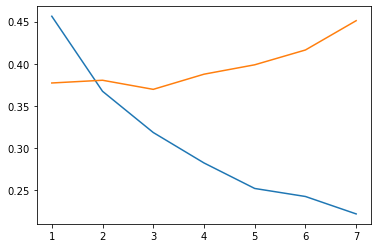

In [16]:
import matplotlib.pyplot as plt
ec=range(1,len(history1.history['acc'])+1)
plt.plot(ec,history1.history['loss'])
plt.plot(ec,history1.history['val_loss'])
plt.show()

In [17]:
ck1=m1.evaluate(tt_x, tt_y)

1805/1805 [==============================] - 9s 5ms/step - loss: 0.4457 - acc: 0.8327


In [35]:
배치크기 = 128
총단어수= 18093
최고문장길이=68
임베딩길이=64
뉴런수=64
뉴런수2=32
d_out=0.5
ec=50
배치사이즈=64

In [36]:
es = EarlyStopping(monitor='val_loss',
                   mode='min', verbose=1, patience=4)
mc2 = ModelCheckpoint('best_k_m2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

m2 = Sequential()
m2.add(Embedding(총단어수, 임베딩길이))
m2.add(LSTM(뉴런수,dropout=d_out,return_sequences=True)) 
m2.add(LSTM(뉴런수2,dropout=d_out))
m2.add(Dense(1, activation='sigmoid'))
m2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history2 = m2.fit(t_x, t_y,epochs=ec,
                  callbacks=[es, mc2],batch_size=배치사이즈, 
                  validation_data=(v_x,v_y) )

Epoch 1/50
1687/1687 [==============================] - 133s 77ms/step - loss: 0.4051 - acc: 0.8100 - val_loss: 0.3500 - val_acc: 0.8450

Epoch 00001: val_acc improved from -inf to 0.84498, saving model to best_k_m2.h5
Epoch 2/50
1687/1687 [==============================] - 129s 77ms/step - loss: 0.3141 - acc: 0.8639 - val_loss: 0.3431 - val_acc: 0.8511

Epoch 00002: val_acc improved from 0.84498 to 0.85114, saving model to best_k_m2.h5
Epoch 3/50
1687/1687 [==============================] - 130s 77ms/step - loss: 0.2801 - acc: 0.8804 - val_loss: 0.3494 - val_acc: 0.8526

Epoch 00003: val_acc improved from 0.85114 to 0.85259, saving model to best_k_m2.h5
Epoch 4/50
1687/1687 [==============================] - 127s 75ms/step - loss: 0.2545 - acc: 0.8927 - val_loss: 0.3653 - val_acc: 0.8508

Epoch 00004: val_acc did not improve from 0.85259
Epoch 5/50
1687/1687 [==============================] - 126s 75ms/step - loss: 0.2337 - acc: 0.9019 - val_loss: 0.3824 - val_acc: 0.8469

Epoch 00005

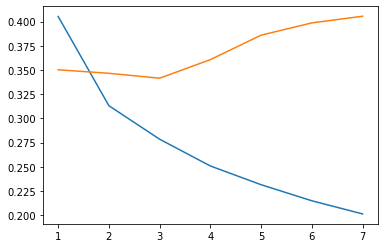

In [24]:
ec=range(1,len(history2.history['acc'])+1)
plt.plot(ec,history2.history['loss'])
plt.plot(ec,history2.history['val_loss'])
plt.show()

In [25]:
ck2=m2.evaluate(tt_x, tt_y)

1805/1805 [==============================] - 22s 12ms/step - loss: 0.4041 - acc: 0.8454


In [37]:
배치크기 = 128
총단어수= 18093
최고문장길이=68
임베딩길이=64
뉴런수=64
뉴런수2=32
d_out=0.5
ec=50
배치사이즈=64
es = EarlyStopping(monitor='val_loss',
                   mode='min', verbose=1, patience=4)
mc3 = ModelCheckpoint('best_k_m3.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

m3 = Sequential()
m3.add(Embedding(총단어수, 임베딩길이))
m3.add(GRU(뉴런수,dropout=d_out,return_sequences=True)) 
m3.add(GRU(뉴런수2,dropout=d_out))
m3.add(Dense(1, activation='sigmoid'))
m3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history3 = m3.fit(t_x, t_y,epochs=ec,
                  callbacks=[es, mc3],batch_size=배치사이즈, 
                  validation_data=(v_x,v_y) )

Epoch 1/50
1687/1687 [==============================] - 125s 72ms/step - loss: 0.4017 - acc: 0.8131 - val_loss: 0.3470 - val_acc: 0.8481

Epoch 00001: val_acc improved from -inf to 0.84814, saving model to best_k_m3.h5
Epoch 2/50
1687/1687 [==============================] - 124s 74ms/step - loss: 0.3110 - acc: 0.8672 - val_loss: 0.3440 - val_acc: 0.8516

Epoch 00002: val_acc improved from 0.84814 to 0.85162, saving model to best_k_m3.h5
Epoch 3/50
1687/1687 [==============================] - 126s 74ms/step - loss: 0.2778 - acc: 0.8838 - val_loss: 0.3412 - val_acc: 0.8519

Epoch 00003: val_acc improved from 0.85162 to 0.85188, saving model to best_k_m3.h5
Epoch 4/50
1687/1687 [==============================] - 124s 74ms/step - loss: 0.2535 - acc: 0.8961 - val_loss: 0.3586 - val_acc: 0.8480

Epoch 00004: val_acc did not improve from 0.85188
Epoch 5/50
1687/1687 [==============================] - 130s 77ms/step - loss: 0.2343 - acc: 0.9030 - val_loss: 0.3615 - val_acc: 0.8447

Epoch 00005

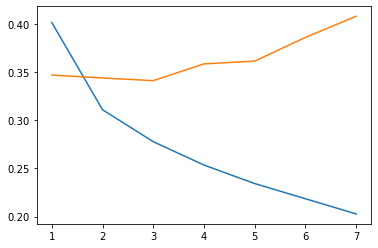

In [38]:
ec=range(1,len(history3.history['acc'])+1)
plt.plot(ec,history3.history['loss'])
plt.plot(ec,history3.history['val_loss'])
plt.show()

In [29]:
ck3=m3.evaluate(tt_x, tt_y)

1805/1805 [==============================] - 16s 9ms/step - loss: 0.4087 - acc: 0.8449


In [30]:
배치크기 = 128
총단어수= 18093
최고문장길이=68
임베딩길이=64
뉴런수=64
뉴런수2=32
d_out=0.5
ec=50
배치사이즈=64
es = EarlyStopping(monitor='val_loss',
                   mode='min', verbose=1, patience=4)
mc4 = ModelCheckpoint('best_K_m4.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

m4 = Sequential()
m4.add(Embedding(총단어수, 임베딩길이))
m4.add(Bidirectional(LSTM(뉴런수,dropout=d_out,return_sequences=True)))
m4.add(Bidirectional(LSTM(뉴런수2,dropout=d_out)))
m4.add(Dense(1, activation='sigmoid'))
m4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history4 = m4.fit(t_x, t_y,epochs=ec,
                  callbacks=[es, mc4],batch_size=배치사이즈, 
                  validation_data=(v_x,v_y) )

Epoch 1/50
1687/1687 [==============================] - 175s 101ms/step - loss: 0.3980 - acc: 0.8154 - val_loss: 0.3556 - val_acc: 0.8432

Epoch 00001: val_acc improved from -inf to 0.84317, saving model to best_K_m4.h5
Epoch 2/50
1687/1687 [==============================] - 172s 102ms/step - loss: 0.3067 - acc: 0.8687 - val_loss: 0.3457 - val_acc: 0.8501

Epoch 00002: val_acc improved from 0.84317 to 0.85006, saving model to best_K_m4.h5
Epoch 3/50
1687/1687 [==============================] - 177s 105ms/step - loss: 0.2673 - acc: 0.8860 - val_loss: 0.3571 - val_acc: 0.8464

Epoch 00003: val_acc did not improve from 0.85006
Epoch 4/50
1687/1687 [==============================] - 176s 104ms/step - loss: 0.2351 - acc: 0.9001 - val_loss: 0.3865 - val_acc: 0.8462

Epoch 00004: val_acc did not improve from 0.85006
Epoch 5/50
1687/1687 [==============================] - 187s 111ms/step - loss: 0.2117 - acc: 0.9107 - val_loss: 0.4050 - val_acc: 0.8375

Epoch 00005: val_acc did not improve fro

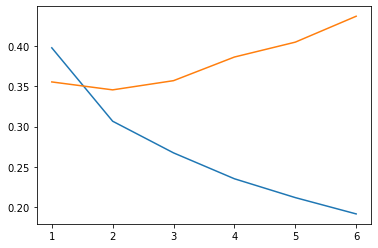

In [31]:
ec=range(1,len(history4.history['acc'])+1)
plt.plot(ec,history4.history['loss'])
plt.plot(ec,history4.history['val_loss'])
plt.show()

In [32]:
ck4=m4.evaluate(tt_x, tt_y)

1805/1805 [==============================] - 34s 19ms/step - loss: 0.4363 - acc: 0.8383


In [33]:
print(f'모델1:{ck1}')#RNN
print(f'모델2:{ck2}')#LSTM
print(f'모델3:{ck3}')#GRU
print(f'모델4:{ck4}')#양방향LSTM

모델1:[0.4457429349422455, 0.832730233669281]
모델2:[0.40409108996391296, 0.845352053642273]
모델3:[0.4086989164352417, 0.8449019193649292]
모델4:[0.43631112575531006, 0.8382880091667175]


In [ ]:
loaded_model = load_model('best_k_m2.h5.h5')
loaded_model.evaluate(test_inputs,test_outputs)[1]

In [ ]:
def 문장_전처리(문장):
    문장 = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', 문장)
    문장 = okt.morphs(문장, stem=True)
    문장 = [w for w in 문장 if not w in s_w] 
    encoded = token.texts_to_sequences([문장])
    pad_new = pad_sequences(encoded, maxlen = w_l) 
    score = float(loaded_model.predict(pad_new))
    if(score > 0.5):
        print(f"{score * 100:.2f}% 확률로 긍정 리뷰입니다.\n")
    else:
        print(f"{(1 - score) * 100:.2f}% 확률로 부정 리뷰입니다.\n")

In [ ]:
문장_전처리('재미있는 영화였어')

In [ ]:
문장_전처리('내 인생 최악의 영화였어')